**Project**

*   Pre-processing of image data.
*   Visualization of images.
*   Building CNN.
*   Use transfer learning
*   Hypertune
*   Evaluate the Model.



In [2]:
#Importing the libraries

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve

from google.colab.patches import cv2_imshow
from keras.models import load_model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.applications.vgg16 import VGG16    # Transfer learning here too (AGV comments), 

from tensorflow.keras.applications.resnet50 import ResNet50


**HANDS-ON**

1.   **Mounting Google Drive on to the Google Colab instance**

2.   **Set the appropriate path for the datsaet zip provided**

3.   **Extracting the dataset.zip to the present working directory**



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
images_path = '/content/drive/MyDrive/archive (1).zip'

In [7]:
# Extract the files from dataset, as the dataset is as zip file.
from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

In [8]:
#Checking the list of files in the present working directory. Ensuring 'dataset' folder has been generated
!ls

chest_xray  drive  Model1.h5  sample_data


**Adding Gaussian filter to some medical images**

Normal (768, 1072, 3)
Normal with Gaussian Filter (768, 1072, 3)


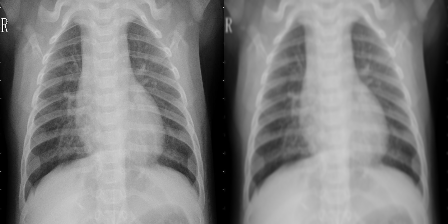

In [92]:
#View some of the images from train & val
n1 = cv2.imread('/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
print ('Normal', n1.shape)
p1 = cv2.GaussianBlur(n1,(15,15),cv2.BORDER_DEFAULT)
print ('Normal with Gaussian Filter',p1.shape)
Hori = np.concatenate((cv2.resize(n1,(224,224)), cv2.resize(p1,(224,224))), axis=1)
cv2_imshow(Hori)



**Appending data from different folders TRAIN, TEST and VALIDATION**

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_data('/content/chest_xray/train')
test = get_data('/content/chest_xray/test')
val = get_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**Pre-processing of image data**

In [31]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


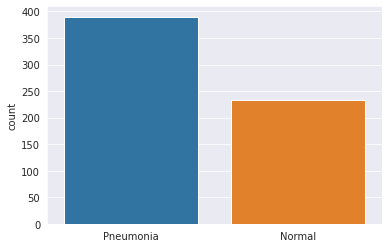

In [82]:
#Checking the distribution of the data
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

l2 = []
for i in test:
    if(i[1] == 0):
        l2.append("Pneumonia")
    else:
        l2.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l2)     

In [33]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
print('x_train.shape', x_train.shape)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)
print('x_val.shape', x_val.shape)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
print('x_test.shape', x_test.shape)


x_train.shape (5216, 224, 224, 1)
x_val.shape (16, 224, 224, 1)
x_test.shape (624, 224, 224, 1)


In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [36]:
datagen.fit(x_train)


x_train.shape AFTER DataGEN ()


In [16]:
print('x_train.shape AFTER DataGEN', x_train.shape)

x_train.shape AFTER DataGEN (5216, 224, 224, 1)


**Model Creation**

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))  #Fully connected layer
model.add(Dense(1, activation='sigmoid'))  #binary classification


In [ ]:
#Compiling Model
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [ ]:
#Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 64)      

**TRAIN the MODEL**

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor='val_loss', patience=5), 
    ModelCheckpoint('../working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]
#stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model_history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs=5 ,  #limit the number of epochs to run faster only, as a demo
                                  validation_data=datagen.flow(x_val, y_val),   #16 samples for validation
                                  callbacks=[callbacks1]) 

Epoch 1/5
163/163 [==============================] - 247s 2s/step - loss: 0.1992 - accuracy: 0.9252 - val_loss: 0.9760 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 241s 1s/step - loss: 0.1866 - accuracy: 0.9237 - val_loss: 0.9725 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 242s 1s/step - loss: 0.1757 - accuracy: 0.9381 - val_loss: 1.0908 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 241s 1s/step - loss: 0.1711 - accuracy: 0.9392 - val_loss: 0.3214 - val_accuracy: 0.8750
Epoch 5/5
163/163 [==============================] - 241s 1s/step - loss: 0.1655 - accuracy: 0.9387 - val_loss: 0.8858 - val_accuracy: 0.8750


**Analysis after Model Training**

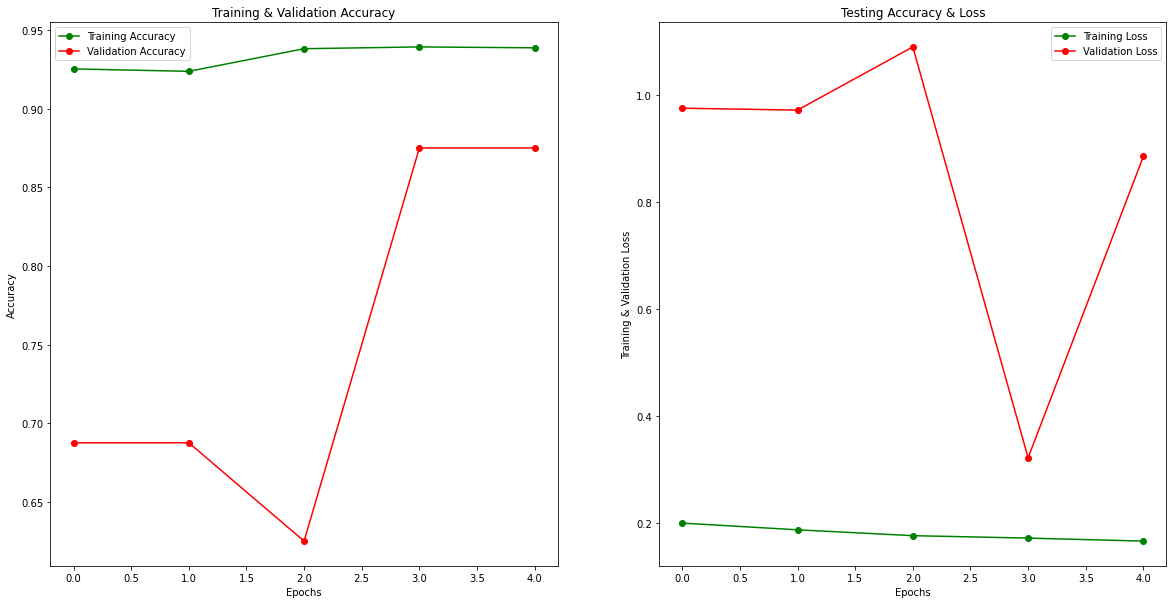

In [ ]:
history=model_history
noepochs=5
def plot_history(history, noepochs):
  epochs = [i for i in range(noepochs)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

**Testing Model**

In [ ]:
print("Test Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Test Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 7s 348ms/step - loss: 0.2956 - accuracy: 0.9071
Test Loss of the model is -  0.29560428857803345
20/20 [==============================] - 7s 344ms/step - loss: 0.2956 - accuracy: 0.9071
Test Accuracy of the model is -  90.70512652397156 %


**Saving Model 1**

In [ ]:
#model.save('Model1.h5') 



**Loading Model 1**

In [17]:
model1 = load_model('Model1.h5')
#model1 = tf.keras.models.load_model('path_to_filename/filename.h5')

**Predictions and some Metrics with Model 1**

In [ ]:
#predictions = model1.predict(x_test)
#predictions = predictions.reshape(1,-1)[0]
#predictions[:15]

y_predict = model1.predict(x_test)
y_predict = y_predict.reshape(1,-1)[0]
for i in range(len(y_test)):
  if y_predict[i]>0.5:
    y_predict[i]=1 
  else:
    y_predict[i]=0


In [ ]:
print(classification_report(y_test, y_predict, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 24.0, 'Predicted label')

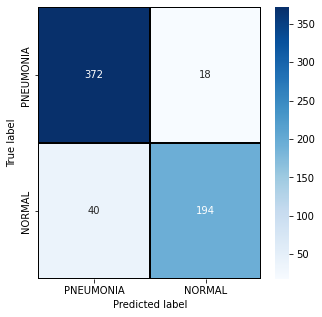

In [ ]:
cm = confusion_matrix(y_test,y_predict)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

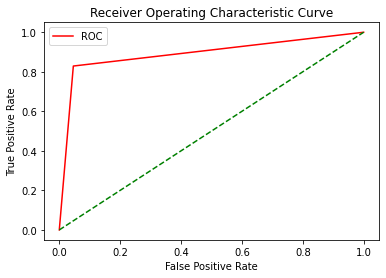

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(y_test, y_predict)
plot_roc_curve(fper, tper)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tper * (1-fper))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=1.000000, G-Mean=0.889


**Individual Predictions with Model 1**

In [ ]:
img_arr = cv2.imread(os.path.join('/content/chest_xray/test/NORMAL/IM-0025-0001.jpeg'), cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (img_size, img_size))
resized_arr = resized_arr.reshape(-1, img_size, img_size, 1)
predictions = model.predict(resized_arr)
print(predictions)

[[0.98352826]]


**MODEL 2 with GRIDSEARCH**

In [ ]:
# keras_estimator = KerasClassifier(build_fn=model1, verbose=1)
# # define the grid search parameters
# param_grid = {
#     'batch_size':[32, 50, 64],
#     'learning_rate':[0.01,0.001,.001]
# }

# kfold_splits = 3
# grid = GridSearchCV(estimator=keras_estimator,  
#                     verbose=4,
#                     cv=kfold_splits,  
#                     param_grid=param_grid,n_jobs=-1)  

In [ ]:
# grid_result = grid.fit(x_train,y_train) 

# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


## **Transfer Learning**

In [18]:

modelVGG = VGG16(include_top=True, weights='imagenet')   #We Added top/input layer, importing the model. Includes input layer
modelVGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# #We need to indicate, until what layer (from top to down) we want to make the transfer.
# transfer_layer = modelVGG.get_layer('block5_pool')  #From top to block5_pool, funtion to import the layers, and apply the transfer layers
# vgg_model = Model(inputs=modelVGG.input, outputs=transfer_layer.output)  #From these layers I am creating a new model. Feature extracted part. 
# #how to build the model, call the model Model function, input used

In [20]:
#We have to say which layers we want to train, and which ones to mantain fix. 
# we will choose which layers of VGG16 we actually want to fine-tune. Here we'll freeze all but the last convolutional layer
for layer in modelVGG.layers[0:17]:  #We are saying from layer 0 to 17 
    layer.trainable = False    #Every layer has this trainable parameter, by default is True, 

In [21]:
for layer in modelVGG.layers:  #loop to check
    print(layer.name, layer.trainable)  # name only if it is trainable or not. Wi

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
predictions True


**We had to recreated Image data Gnerator with color_mode=rgb**

In [73]:
# parent directory where images are stored in drive, careful how you build this
parent_dir = '/content/chest_xray'

# path to the training and validation datasets within the parent directory
train_dir = os.path.join(parent_dir, 'train')
validation_dir = os.path.join(parent_dir, 'val')

#Now lets Re shape! lets build the data generator
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0)
val_datagen  = ImageDataGenerator(rescale = 1.0/255.) 
# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,        #Dynamically runs every time, where to write them
                                                    batch_size=32,
                                                    class_mode='binary',     #two folders, one per class
                                                    target_size=(224, 224),
                                                    color_mode='rgb')     #Reshaping for this format

# Flowing validation images in batches of 20 images using test_datagen generator
validation_generator =  val_datagen.flow_from_directory(validation_dir,  #location of the images, this is dynamic, changes on each run
                                                         batch_size=32,
                                                         class_mode  = 'binary',  #We have TWO folders, one per each class
                                                         target_size = (224, 224),
                                                         color_mode='rgb')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [74]:
test_dir = os.path.join(parent_dir, 'test')

test_generator =  val_datagen.flow_from_directory(test_dir,  #location of the images, this is dynamic, changes on each run
                                                         batch_size=32,
                                                         class_mode  = 'binary',  #We have TWO folders, one per each class
                                                         target_size = (224, 224),
                                                         color_mode='rgb')

Found 624 images belonging to 2 classes.


In [53]:
tl_model_1= Sequential()  #we are building a sequential model

# adding the convolutional part of the VGG16 model from above. And thats all!
tl_model_1.add(modelVGG)

# flattening the output of the VGG16 model because it is from a convolutional layer.
tl_model_1.add(Flatten())   #We were doing the flatten in the previous steps

# adding a dense output layer. We can add more layers before, can use Relu too (in the previous one)
tl_model_1.add(Dense(1, activation='sigmoid'))

#This part is very important to understand since it is the logic behind

In [54]:
tl_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 138,358,545
Trainable params: 126,003,665
Non-trainable params: 12,354,880
_________________________________________________________________


In [55]:
#Compiling Model
tl_model_1.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

**VGG MODEL**

In [56]:
callbacks2 = [ 
    EarlyStopping(monitor='val_loss', patience=5), 
    ModelCheckpoint('../working/model_tl.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]
#stop_early = EarlyStopping(monitor='val_loss', patience=5)

modeltlhistory = tl_model_1.fit(train_generator, validation_data=validation_generator, epochs=5 ,  #limit the number of epochs to run faster only, as a demo
                                                          callbacks=[callbacks2])                               #16 samples for validation
                                 

Epoch 1/5
163/163 [==============================] - 3056s 19s/step - loss: 0.6711 - accuracy: 0.6620 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 3030s 19s/step - loss: 0.6170 - accuracy: 0.7429 - val_loss: 0.7287 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 3038s 19s/step - loss: 0.5873 - accuracy: 0.7429 - val_loss: 0.7645 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 3036s 19s/step - loss: 0.5747 - accuracy: 0.7429 - val_loss: 0.7937 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 3063s 19s/step - loss: 0.5712 - accuracy: 0.7429 - val_loss: 0.8109 - val_accuracy: 0.5000


In [59]:
history=modeltlhistory
noepochs=5
def plot_history(history, noepochs):
  epochs = [i for i in range(noepochs)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

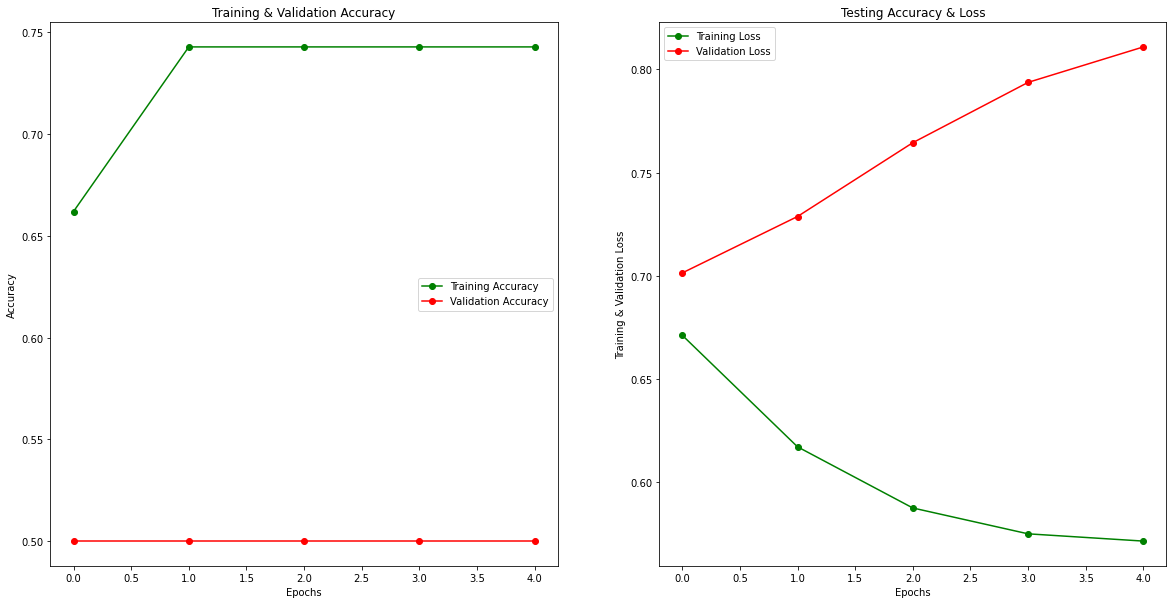

In [60]:
plot_history(history, noepochs)

In [75]:
print("Test Loss of the VGG16 model is - " , model_TL_1.evaluate(test_generator)[0])
print("Test Accuracy of VGG16 the model is - " , model_TL_1.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 327s 16s/step - loss: 0.6872 - accuracy: 0.6250
Test Loss of the VGG16 model is -  0.6871979236602783
20/20 [==============================] - 326s 16s/step - loss: 0.6872 - accuracy: 0.6250
Test Accuracy of VGG16 the model is -  62.5 %


In [57]:
#tl_model_1.save('Model_VGG_1_2.h5') 


In [62]:
model_TL_1 = load_model('/content/Model_VGG_1_2.h5')

In [88]:
y_predict1 = model_TL_1.predict(test_generator)
#y_predict1 = y_predict1.reshape(1,-1)[0]
for i in range(len(y_test)):
  if y_predict1[i]>0.5:
    y_predict1[i]=1 
  else:
    y_predict1[i]=0

print(classification_report(y_test, y_predict1, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))   



                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       390
   Normal (Class 1)       0.38      1.00      0.55       234

           accuracy                           0.38       624
          macro avg       0.19      0.50      0.27       624
       weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 24.0, 'Predicted label')

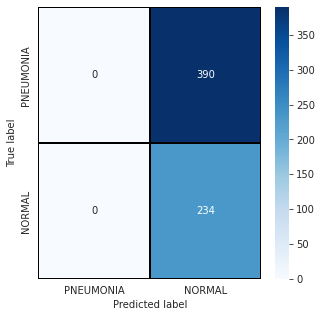

In [84]:
cm = confusion_matrix(y_test,y_predict1)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')


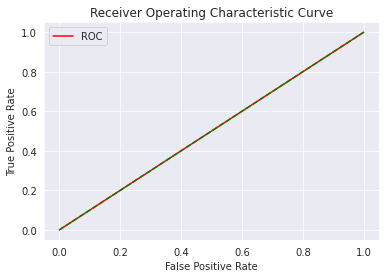

In [86]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(y_test, y_predict1)
plot_roc_curve(fper, tper)

In [87]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tper * (1-fper))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=2.000000, G-Mean=0.000


**OTHER WAY TO PREDICT FROM PREVIOUS VGG16 model**

In [89]:
predgen = model_TL_1.predict_generator(test_generator, steps=len(test_generator), verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


20/20 [==============================] - 326s 16s/step


In [90]:
pred = np.argmax(predgen,axis = 1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [91]:
print(classification_report(y_test, pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))   


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**RESNET50 IMPLEMENTATION**

In [3]:
resnet=ResNet50(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

#resnet.summary()

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
x=resnet.output
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activa

# BIND ALL 
model_TL_2 = Model(resnet.input, outputs=preds)

# FREEZE THE WEIGHTS OF resnet BASE MODEL 
# SO THAT THEY'RE NON-TRAINABLE
for layer in resnet.layers:
    layer.trainable = False

# for layer in resnet.layers:  #loop to check
#     print(layer.name, layer.trainable) 

model_TL_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [114]:
#Compiling Model
model_TL_2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [115]:
callbacks3 = [ 
    EarlyStopping(monitor='val_loss', patience=5), 
    ModelCheckpoint('../working/model_tl.best2.hdf5',monitor='loss', save_best_only=True) # saving the best model
]
#stop_early = EarlyStopping(monitor='val_loss', patience=5)

modeltlhistoryTL_2 = model_TL_2.fit(train_generator, validation_data=validation_generator, epochs=5 ,  #limit the number of epochs to run faster only, as a demo
                                                          callbacks=[callbacks3])                               #16 samples for validation
                                 

Epoch 1/5
163/163 [==============================] - 879s 5s/step - loss: 0.5579 - accuracy: 0.7429 - val_loss: 0.8069 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 867s 5s/step - loss: 0.5157 - accuracy: 0.7431 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 860s 5s/step - loss: 0.4820 - accuracy: 0.7494 - val_loss: 0.7140 - val_accuracy: 0.5625
Epoch 4/5
163/163 [==============================] - 858s 5s/step - loss: 0.4576 - accuracy: 0.7628 - val_loss: 0.7711 - val_accuracy: 0.5625
Epoch 5/5
163/163 [==============================] - 856s 5s/step - loss: 0.4388 - accuracy: 0.7724 - val_loss: 0.7471 - val_accuracy: 0.5625


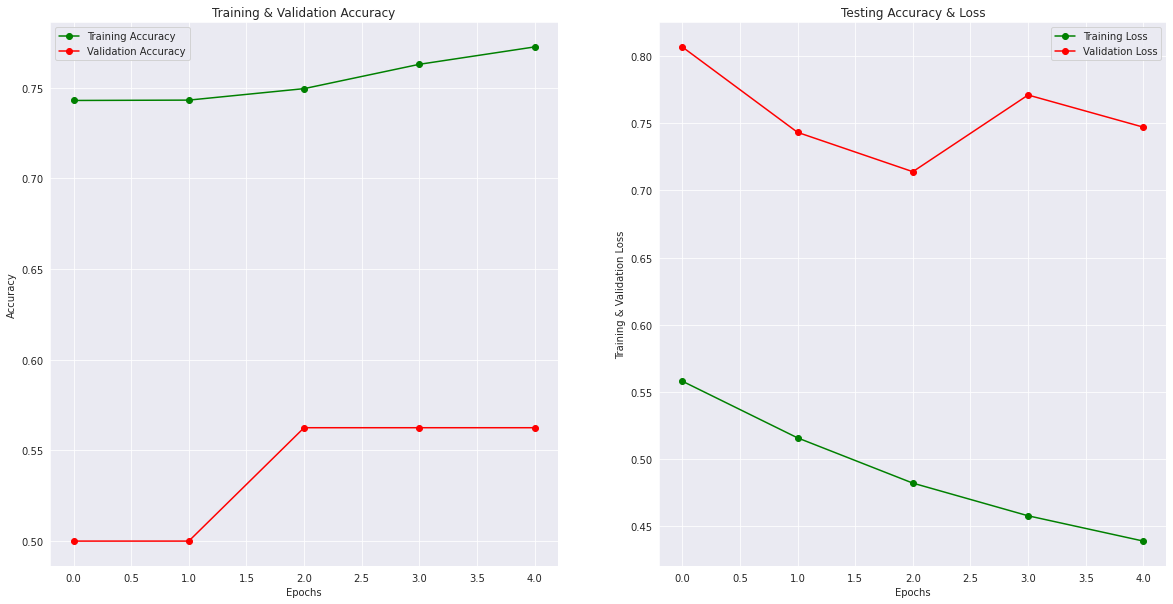

In [116]:
history=modeltlhistoryTL_2
noepochs=5
plot_history(history, noepochs)


In [118]:
print("Test Loss of the VGG16 model is - " , model_TL_2.evaluate(test_generator)[0])
print("Test Accuracy of VGG16 the model is - " , model_TL_2.evaluate(test_generator)[1]*100 , "%")


20/20 [==============================] - 139s 7s/step - loss: 0.5605 - accuracy: 0.6795
Test Loss of the VGG16 model is -  0.5605298280715942
20/20 [==============================] - 105s 5s/step - loss: 0.5605 - accuracy: 0.6795
Test Accuracy of VGG16 the model is -  67.94871687889099 %


In [ ]:
model_TL_2.save('Model_Resnet_1_2.h5') 
#model_TL_2 = load_model('/content/Model_Resnet_1_2.h5')


In [119]:
y_predict2 = model_TL_1.predict(test_generator)
#y_predict1 = y_predict1.reshape(1,-1)[0]
for i in range(len(y_test)):
  if y_predict1[i]>0.5:
    y_predict1[i]=1 
  else:
    y_predict1[i]=0

print(classification_report(y_test, y_predict1, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


20/20 [==============================] - 108s 5s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(classification_report(y_test, pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))